In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/ANN

/gdrive/My Drive/ANN


In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

tfk = tf.keras
tfkl = tf.keras.layers
from tensorflow.keras import layers
from tensorflow.keras import regularizers

#from tensorflow.keras.applications.EfficientNetV2L import preprocess_input


In [4]:
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 36.9 MB/s 


In [5]:
seed = 21

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [7]:
dataset_dir = "Dataset/splitted_cleaned_by_Alberto"
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

In [8]:
labels = ['Species1',       # 0
          'Species2',       # 1
          'Species3',       # 2
          'Species4',       # 3
          'Species5',       # 4
          'Species6',       # 5
          'Species7',       # 6
          'Species8']       # 7

In [9]:
aug_train_data_gen = ImageDataGenerator(rotation_range=180,
                                        height_shift_range=0.4,
                                        width_shift_range=0.4,
                                        zoom_range=0.4,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect'
                                        #rescale=1/255.,
                                        #preprocessing_function = preprocess_input
                                        )

aug_val_data_gen = ImageDataGenerator(rotation_range=180,
                                      height_shift_range=0.4,
                                      width_shift_range=0.4,
                                      zoom_range=0.4,
                                      horizontal_flip=True,
                                      vertical_flip=True, 
                                      fill_mode='reflect'
                                      #rescale=1/255.,
                                      #preprocessing_function = preprocess_input
                                      )
test_data_gen = ImageDataGenerator(#preprocessing_function = preprocess_input
                                   )

In [10]:
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None,
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)
aug_val_gen = aug_val_data_gen.flow_from_directory(directory=validation_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None,
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=False,
                                                       seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=8,
                                             shuffle=False,
                                             seed=seed)

Found 3060 images belonging to 8 classes.
Found 571 images belonging to 8 classes.
Found 197 images belonging to 8 classes.


In [11]:
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join("Models/EfficientNet/Checkpoints")
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [12]:
#def create_class_weight(labels_dict,mu=0.15):
#    total = np.sum(list(labels_dict.values()))
#    keys = labels_dict.keys()
#    class_weight = dict()
    
#    for key in keys:
#        score = math.log(total/float(labels_dict[key]))
#        class_weight[key] = score if score > 1.0 else 1.0
    
#    return class_weight

#labels_dict = {0: 1.7458, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1.568, 6: 1, 7: 1} 
#class_weights = create_class_weight(labels_dict)
#class_weights

In [13]:
input_shape = (96, 96, 3)
epochs = 200

473176280/473176280 [==============================] - 6s 0us/step
Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 96, 96, 3)    0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 48, 48, 32)   864         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 48, 48, 32)   128         ['stem_conv[0][0]']              
                

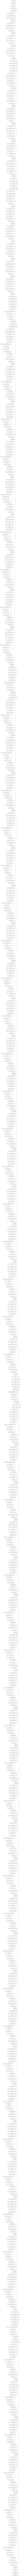

In [14]:
supernet = tfk.applications.EfficientNetV2L(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3),
    include_preprocessing=True
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [15]:
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    512, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-l (Functiona  (None, 3, 3, 1280)       117746848 
 l)                                                              
                                                                 
 Flattening (Flatten)        (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 512)               5898752   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

In [16]:
tl_callbacks = create_folders_and_callbacks(model_name='EfficientNet_TL')

tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = aug_val_gen,
    callbacks = tl_callbacks,
    class_weight = {0: 1.7458, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1.568, 6: 1, 7: 1} 
).history

Epoch 1/200
383/383 [==============================] - 584s 1s/step - loss: 2.2864 - accuracy: 0.2438 - val_loss: 1.5155 - val_accuracy: 0.4326
Epoch 2/200
383/383 [==============================] - 455s 1s/step - loss: 1.8913 - accuracy: 0.3627 - val_loss: 1.4297 - val_accuracy: 0.4431
Epoch 3/200
383/383 [==============================] - 455s 1s/step - loss: 1.7968 - accuracy: 0.3912 - val_loss: 1.3173 - val_accuracy: 0.5026
Epoch 4/200
383/383 [==============================] - 458s 1s/step - loss: 1.7015 - accuracy: 0.4369 - val_loss: 1.2940 - val_accuracy: 0.4991
Epoch 5/200
383/383 [==============================] - 455s 1s/step - loss: 1.6234 - accuracy: 0.4523 - val_loss: 1.2203 - val_accuracy: 0.5482
Epoch 6/200
383/383 [==============================] - 468s 1s/step - loss: 1.6247 - accuracy: 0.4500 - val_loss: 1.2052 - val_accuracy: 0.5569
Epoch 7/200
383/383 [==============================] - 462s 1s/step - loss: 1.5900 - accuracy: 0.4775 - val_loss: 1.2312 - val_accuracy:

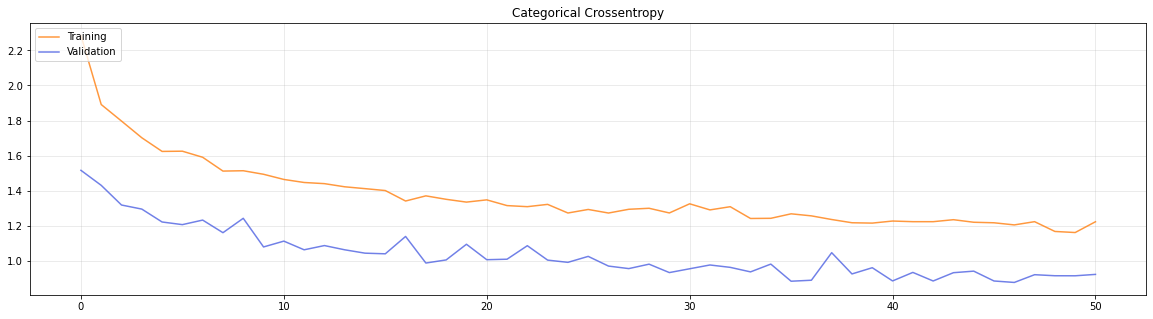

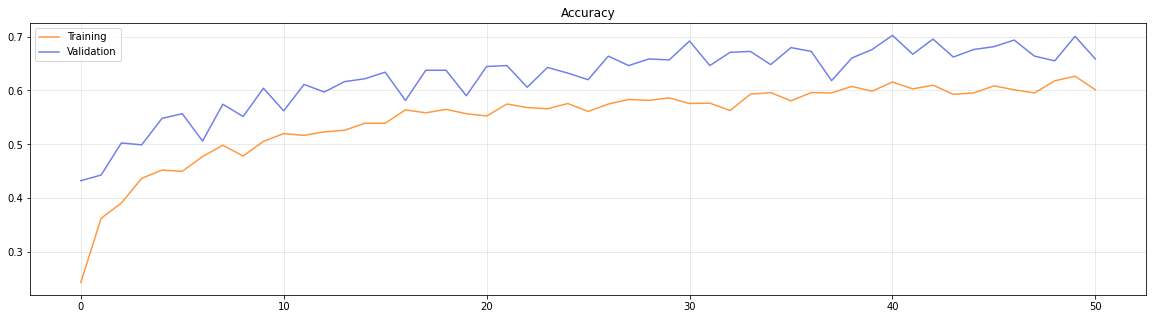

In [17]:
plt.figure(figsize=(20,5))
plt.plot(tl_history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(tl_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [18]:
tl_model.save("Models/EfficientNet/TransferLearning")

In [19]:
predictions = tl_model.predict(test_gen)
predictions.shape
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())   

25/25 [==============================] - 48s 2s/step


Accuracy: 0.6904


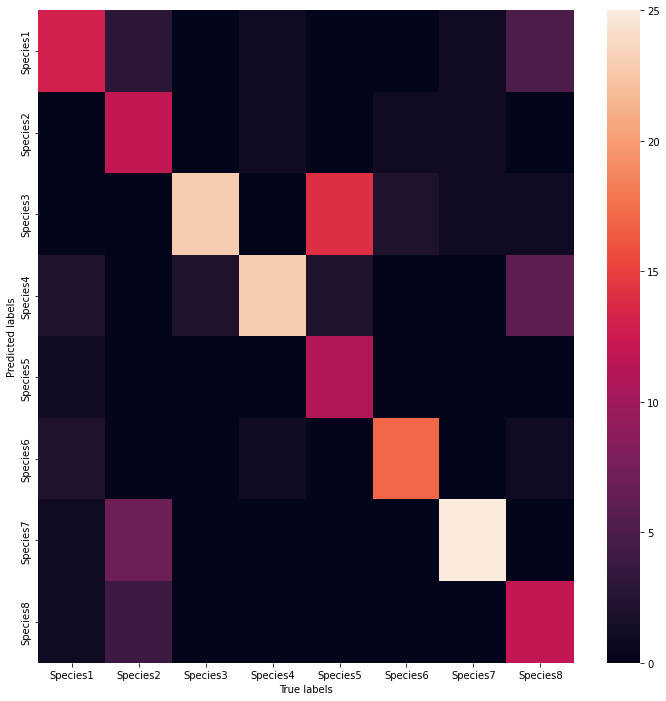

In [20]:
# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Compute the classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
#precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
#recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
#f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
#print('Precision:',precision.round(4))
#print('Recall:',recall.round(4))
#print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(12,12))
sns.heatmap(cm.T, xticklabels=list(class_labels), yticklabels=list(class_labels))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()